<h1> Introduction </h1>

This notebook would serve the purpose of building an ML model for identification of engaged customers which were defined
in TransactionExploration exercise (refer to TransactionExploration notebook or html file saved in same folder for more details). 

The data in <b>rev_users.csv</b> would serve as a base and produced file of <b>Engaged_Customers.csv</b> would provide dependent variable or target for the model training. Users not found in Engaged_Customers.csv file would be tagged as un-engaged. Data from <b>rev_notifications.csv</b> and <b>rev_devices</b> would be used for feature engineering. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pf

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
users = pd.read_csv('./raw_data/rev-users.csv')
users2 = pd.read_csv('./Engaged_Customers.csv')
users = pd.merge(users, users2[['user_id', 'Engaged']], on = ['user_id'], how = 'left', indicator = True)
users['Engaged'].fillna(0, inplace = True)

devices = pd.read_csv('./raw_data/rev-devices.csv')
nots = pd.read_csv('./raw_data/rev-notifications.csv')
trans = pd.read_csv('./raw_data/rev-transactions.csv')

<h2> Profile Reports </h2>

Quick look at profile report for data understanding

In [2]:
users_profile = pf.ProfileReport(users)
users_profile

Number of variables,14
Number of observations,19430
Total Missing (%),4.9%
Total size in memory,2.1 MiB
Average record size in memory,113.0 B
Numeric,4
Categorical,4
Boolean,2
Date,0
Text (Unique),2
Rejected,2


In [3]:
print(devices.describe(include = 'all'))
print('Missing values : {}'.format(devices.isnull().sum(axis = 0)))
print(devices.dtypes)

          brand     user_id
count     19430       19430
unique        3       19430
top     Android  user_13663
freq       9714           1
Missing values : brand      0
user_id    0
dtype: int64
brand      object
user_id    object
dtype: object


In [4]:
print(nots.describe(include = 'all'))
print('Missing values : {}'.format(nots.isnull().sum(axis = 0)))
for col in nots.columns[:-2]:
    print(nots[col].value_counts(normalize = True))

                           reason channel  status    user_id  \
count                      121813  121813  121813     121813   
unique                         17       3       2      18953   
top     REENGAGEMENT_ACTIVE_FUNDS   EMAIL    SENT  user_5133   
freq                        35844   61253   89477        289   

                      created_date  
count                       121813  
unique                      121810  
top     2018-07-15 16:27:12.192706  
freq                             2  
Missing values : reason          0
channel         0
status          0
user_id         0
created_date    0
dtype: int64
REENGAGEMENT_ACTIVE_FUNDS               0.294254
FIFTH_PAYMENT_PROMO                     0.194914
NO_INITIAL_CARD_USE                     0.092117
NO_INITIAL_CARD_ORDER                   0.091419
METAL_GAME_START                        0.068737
LOST_CARD_ORDER                         0.050454
NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER    0.044815
JOINING_ANNIVERSARY            

<b> Users Profile </b>
1. num_referrals, num_successful_referrals are of no use (constant value), city & country as well (high cardinality)
2. created_date can be used to calculate tenure of the customer, though it would be very likely be same as first transaction date of the user
3. plan can be clubbed in 3 categories - STANDARD, PREMIUM & METAL
4. missing num_contacts would be filled with zero
5. attributes_notifications_marketing_push & attributes_notifications_marketing_email are highly correlated, keeping only attributes_notifications_marketing_push since it has slightly less sparsity

<b> Devices Profile </b>
1. Brand column would be good to be used in model

<b> Notifications Profile </b>
1. Only 'SENT' status is useful
2. EMAIL and PUSH channels are almost same (in proportion), few users have been sent SMS which can be used in modelling as a binary flag
3. Number of transactions and total amount of transactions within 7 days of a SENT notification would capture response to users to notifications and can be used as an input to the model

<h1> Feature Engineering </h>

In [5]:

users.drop(['num_referrals', 'num_successful_referrals', 'city', 'country', 'attributes_notifications_marketing_email'], axis =1, inplace = True)
users['Age'] = 2020 - users['birth_year']
users['unknown_cluster'] = np.where(users._merge=='left_only',1,0)
users['attributes_notifications_marketing_push'].fillna(0, inplace = True)
users['num_contacts'].fillna(0, inplace = True)
users['plan'] = users['plan'].map({'STANDARD': 'STANDARD', 'PREMIUM': 'PREMIUM', \
                                   'PREMIUM_OFFER': 'PREMIUM', 'PREMIUM_FREE': 'PREMIUM', \
                                  'METAL': 'METAL', 'METAL_FREE': 'METAL'})


<h2> Tenure of customer </h2>

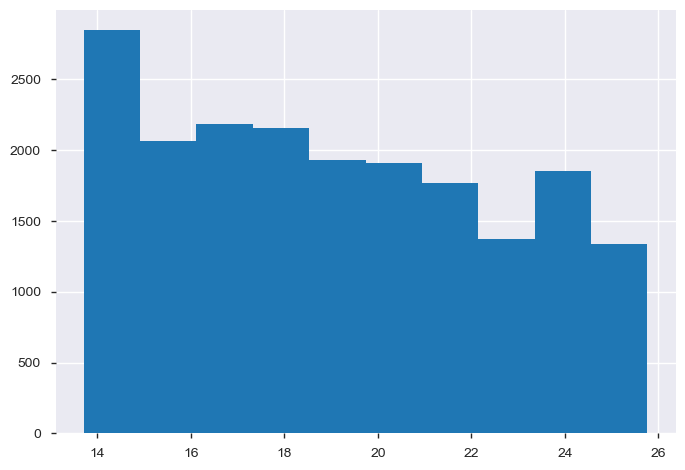

In [6]:
users['created_date'] = pd.to_datetime(users['created_date'], infer_datetime_format = True)
users['tenure'] = (pd.to_datetime('today') - users['created_date'])/np.timedelta64(1, 'M')
users.tenure.hist()

<h2> Brand of user </h2>

In [7]:
users = users.merge(devices, on = 'user_id')
users.brand.value_counts(normalize = True)

Android    0.499949
Apple      0.497838
Unknown    0.002213
Name: brand, dtype: float64

In [8]:
trans.transactions_state.value_counts(normalize = True)

COMPLETED    0.878796
DECLINED     0.056672
REVERTED     0.041100
FAILED       0.014982
PENDING      0.007844
CANCELLED    0.000605
Name: transactions_state, dtype: float64

<h2> Average amount used by user within 7 days of receiving a notification </h2>

In [9]:
users_trans = trans.loc[trans.transactions_state == 'COMPLETED',['user_id', 'amount_usd', 'created_date']].merge(nots.loc[nots.status == 'SENT',['user_id', 'created_date']], on = 'user_id')
users_trans.rename(columns = {'created_date_x':'transaction_date', 'created_date_y':'notification_date'}, inplace = True)
users_trans['transaction_date'] = pd.to_datetime(users_trans['transaction_date'], infer_datetime_format = True)
users_trans['notification_date'] = pd.to_datetime(users_trans['notification_date'], infer_datetime_format = True)
users_trans['date_diff'] = (users_trans['transaction_date'] - users_trans['notification_date'])/np.timedelta64(1,'D')

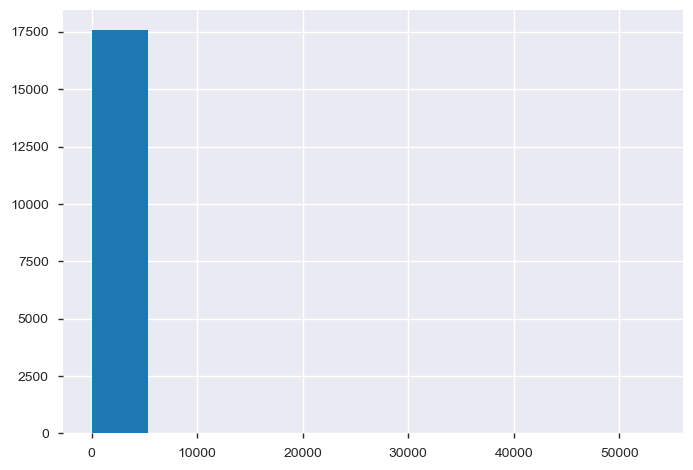

In [10]:
users_trans2 = users_trans.query('date_diff >= 0 & date_diff <= 7')
users_trans2 = users_trans.groupby('user_id')['amount_usd'].mean().reset_index(name = 'Avg_Amount_Used_in_Nots_7Days')
users_trans2['Avg_Amount_Used_in_Nots_7Days'].hist()

In [11]:
print(np.percentile(users_trans2['Avg_Amount_Used_in_Nots_7Days'], 95))

239.4063512336717


Putting a capping for amounts over 300

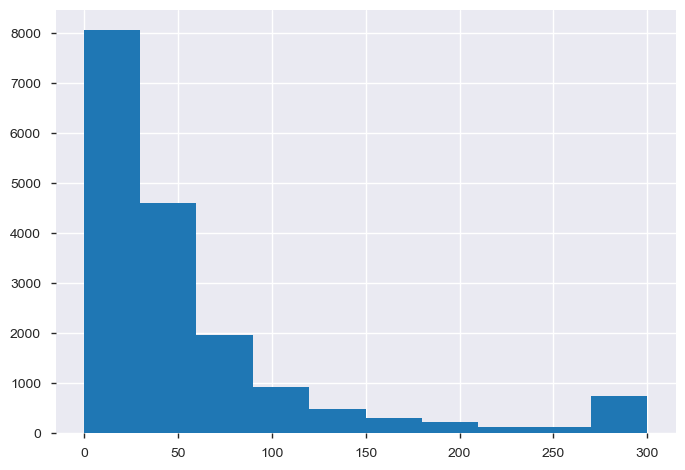

In [12]:
users_trans2['Avg_Amount_Used_in_Nots_7Days'] = np.where(users_trans2['Avg_Amount_Used_in_Nots_7Days'] > 300, 300, users_trans2['Avg_Amount_Used_in_Nots_7Days'])
users_trans2['Avg_Amount_Used_in_Nots_7Days'].hist()

<h2> Number of notifications received through different channels </h2>

In [13]:
nots_channel = nots.loc[nots.status == 'SENT',:].groupby(['user_id', 'channel'])['channel'].count().reset_index(name = 'count_nots')
nots_channel = pd.pivot_table(nots_channel, index = ['user_id'], columns = ['channel'], values = ['count_nots'], aggfunc = [np.sum]).reset_index()
nots_channel.columns = ['user_id', 'EMAIL', 'PUSH', 'SMS']
nots_channel.fillna(0, inplace = True)
nots_channel.head()

,user_id,EMAIL,PUSH,SMS
0,user_0,2.0,6.0,0.0
1,user_1,2.0,0.0,0.0
2,user_10,3.0,3.0,0.0
3,user_100,2.0,2.0,0.0
4,user_1000,5.0,10.0,1.0


In [14]:
users = users.merge(users_trans2, on = 'user_id')
users = users.merge(nots_channel, on = 'user_id')

In [15]:
plan_dummy = pd.get_dummies(users.plan, drop_first = True)
brand_dummy = pd.get_dummies(users.brand, drop_first = True)
users = pd.concat([users, plan_dummy],axis = 1)
users = pd.concat([users, brand_dummy], axis = 1)
users.head()

,user_id,birth_year,created_date,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,num_contacts,Engaged,_merge,Age,...,tenure,brand,Avg_Amount_Used_in_Nots_7Days,EMAIL,PUSH,SMS,PREMIUM,STANDARD,Apple,Unknown
0,user_0,1989,2018-01-13 05:15:15.599466,1,STANDARD,1.0,3,1.0,both,31,...,25.376768,Apple,36.138857,2.0,6.0,0.0,0,1,1,0
1,user_1,1975,2018-01-29 03:38:46.676876,0,STANDARD,0.0,21,1.0,both,45,...,24.853292,Apple,50.046930,2.0,0.0,0.0,0,1,1,0
2,user_5,1993,2018-01-04 17:45:03.907804,1,STANDARD,0.0,0,0.0,both,27,...,25.655355,Apple,38.381190,8.0,2.0,0.0,0,1,1,0
3,user_6,1978,2018-01-24 19:04:50.876183,0,STANDARD,0.0,0,0.0,left_only,42,...,24.996437,Apple,10.000000,2.0,0.0,0.0,0,1,1,0
4,user_7,1989,2018-01-11 19:11:45.757486,0,STANDARD,1.0,0,0.0,both,31,...,25.423393,Apple,214.714000,2.0,0.0,0.0,0,1,1,0


<h1> Modelling Iteration </h1>

<h2> Check for Multi-collinearity </h2>

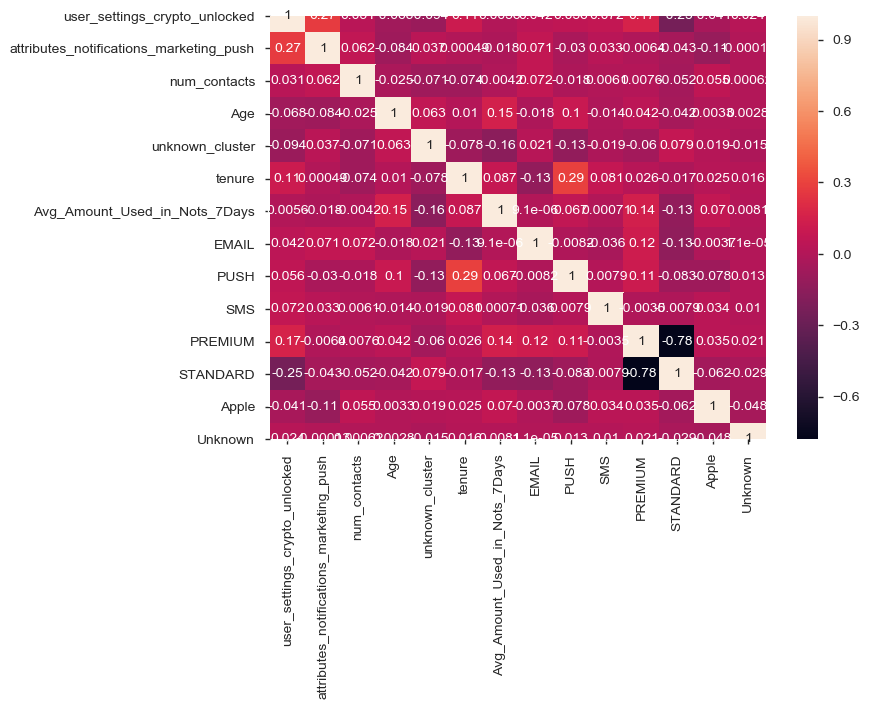

In [16]:
features = ['user_settings_crypto_unlocked', 'attributes_notifications_marketing_push', \
            'num_contacts', 'Age', 'unknown_cluster', 'tenure', 'Avg_Amount_Used_in_Nots_7Days', \
           'EMAIL', 'PUSH', 'SMS', 'PREMIUM', 'STANDARD', 'Apple', 'Unknown']
target = 'Engaged'

import seaborn as sns
sns.heatmap(users[features].corr(), annot = True)

>> Correlation plot reveals high correlation between these combinations: PREMIUM & STANDARD cards, PUSH notifications & TENURE, 
user_settings_crypto_unlocked & attributes_notifications_marketing_push

>> Will drop STANDARD, PUSH & attributes_notifications_marketing_push

<h2> Testing all algorithms </h2>

LR: 0.7040633379369386 (0.012896465578189631)
LDA: 0.7096049783549783 (0.012941207952060978)
KNN: 0.6690329803902565 (0.012546086689127376)
CART: 0.6502056478968792 (0.010509582817375109)
NB: 0.7187699893390191 (0.012783691363454839)
SVM: 0.713371000113071 (0.00653223202615802)
RF: 0.7190560993732635 (0.010218263744503648)
AB: 0.7322710715901014 (0.008156726807481043)
GB: 0.7378839871260581 (0.009015085750537529)
XB: 0.7375287725334367 (0.0076887771675387745)


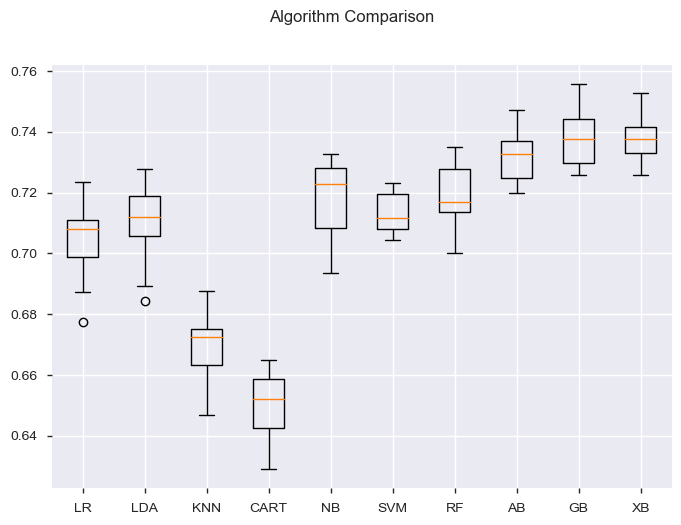

In [17]:
new_features = ['user_settings_crypto_unlocked', 'num_contacts', 'Age', 'unknown_cluster', 'tenure', \
                'Avg_Amount_Used_in_Nots_7Days', 'EMAIL', 'SMS', 'PREMIUM', 'Apple', 'Unknown']

X, y = users[new_features].values, users[target].values

from sklearn import model_selection
import xgboost as xgb
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier


X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 100)

# prepare configuration for cross validation test harness
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('XB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "{}: {} ({})".format(name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

>> <b> XGBoost is a clear winner here </b> 

<b> XGB classifier has the best performance </b>

<h2> Hyper-parameter tuning for XGBoost </h2>

In [18]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

folds = 3
param_comb = 5

skf = model_selection.StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = model_selection.RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, \
                        scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )


random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   56.2s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000023E0ECE68E0>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=600,
                                           n_jobs=1, nthread=1,
                                           objective='binary:logistic',
                                           random_stat...
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=True,
                                           subsample=1),
                   iid='deprecated', n_iter

Best Parameters : {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 5, 'colsample_bytree': 0.6}
AUC in training set : 0.7864285032574041
[[ 768  731]
 [ 131 1889]]
Accuracy in testing set : 0.7550440466041489
AUC in testing set : 0.7968158640413741


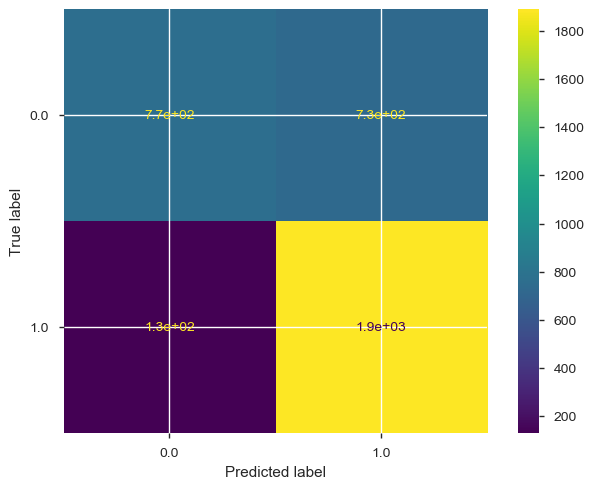

In [19]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score, roc_auc_score
print("Best Parameters : {}".format(random_search.best_params_))
print("AUC in training set : {}".format(random_search.best_score_))
y_pred = random_search.predict(X_test)
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(random_search, X_test, y_test)
print("Accuracy in testing set : {}".format(accuracy_score(y_pred, y_test)))
y_pred = random_search.predict_proba(X_test)[:,1]
print("AUC in testing set : {}".format(roc_auc_score(y_test, y_pred)))

## Check for Overfitting

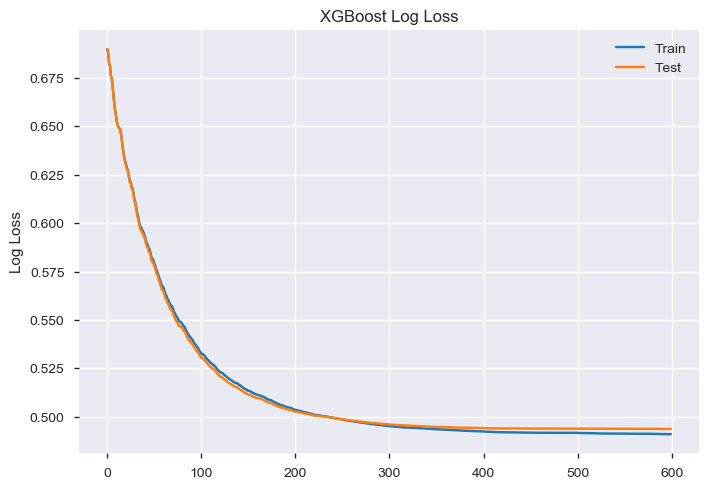

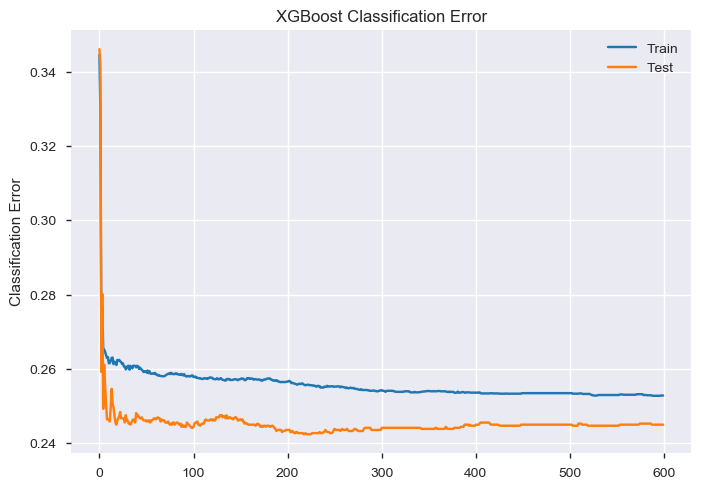

In [20]:

model = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1, \
                     subsample =  1, min_child_weight = 5, max_depth = 5, gamma = 5, colsample_bytree = 0.6)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose = False)
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

>> <b> Log loss and classification error point to a good convergence and do not show any sign of overfitting </b>

## Variable importance

[14:41:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 24 pruned nodes, max_depth=3
[14:41:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 48 pruned nodes, max_depth=3
[14:41:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=5
[14:41:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 56 pruned nodes, max_depth=2
[14:41:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 24 pruned nodes, max_depth=5
[14:41:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 56 pruned nodes, max_depth=2
[14:41:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

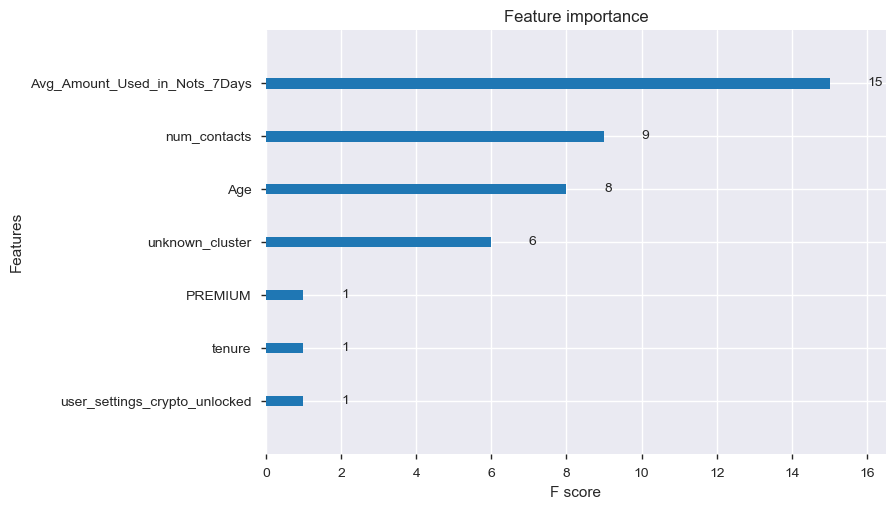

In [21]:
import xgboost as xgb
dtrain = xgb.DMatrix(X, label=y, feature_names = new_features)
final_model = xgb.train(random_search.best_params_, dtrain)
xgb.plot_importance(final_model)

# Experiment for Reducing Churn

Top two drivers of the model are:

> Average spend amount within a week of receiving a notification

> The number of people within user's circle using the platform (num_contacts)


Let's identify which notifications have generated maximum average amount within 1 week

In [22]:
users_trans = trans.loc[trans.transactions_state == 'COMPLETED',['user_id', 'amount_usd', 'created_date']].merge(nots.loc[nots.status == 'SENT',['user_id', 'created_date', 'reason']], on = 'user_id')
users_trans.rename(columns = {'created_date_x':'transaction_date', 'created_date_y':'notification_date'}, inplace = True)
users_trans['transaction_date'] = pd.to_datetime(users_trans['transaction_date'], infer_datetime_format = True)
users_trans['notification_date'] = pd.to_datetime(users_trans['notification_date'], infer_datetime_format = True)
users_trans['date_diff'] = (users_trans['transaction_date'] - users_trans['notification_date'])/np.timedelta64(1,'D')
users_trans = users_trans.query('date_diff >= 0 & date_diff <= 7')
users_trans.groupby('reason')['amount_usd'].mean().reset_index(name = 'Avg_Amount_Spend_in_7Days').sort_values(['Avg_Amount_Spend_in_7Days'], ascending = False)

,reason,Avg_Amount_Spend_in_7Days
13,PREMIUM_ENGAGEMENT_INACTIVE_CARD,540.396642
12,PREMIUM_ENGAGEMENT_FEES_SAVED,295.424951
8,NO_INITIAL_CARD_ORDER,266.732796
11,ONBOARDING_TIPS_ACTIVATED_USERS,164.766110
9,NO_INITIAL_CARD_USE,145.209121
10,NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER,126.818801
15,REENGAGEMENT_ACTIVE_FUNDS,98.318127
4,LOST_CARD_ORDER,74.818020
16,WELCOME_HOME,68.121123
3,JOINING_ANNIVERSARY,65.422278


Basis this the experiment steps can be designed in this way:

1. Calculate propensity of engagement of complete customer base
2. Create deciles of propensity and choose set of customers falling in decile 4-6 with high number of contacts shared on Revolut
3. Coordinate with operation to send them a special notification highlighting number of users using Revolut in their circle
4. Capture their spend amount within next couple of days
5. Measure the difference in averge amount to understand their change in engagement


Metric :

1. Average amount spend before and after notification received
2. Change in number of contacts after receiving notification

